In [1]:
%matplotlib inline
import random
import math

import numpy as np
import gym
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch import nn
from torch.autograd import Variable
from utils import grid_from_state

from atari_wrappers import wrap_deepmind

## Utils

In [2]:
def process_state(state):
    state = np.array(state, dtype='float32').transpose((2, 0, 1)) # change WHC to CWH for pytorch
    state /= 255. # rescale 0-1
    state = torch.from_numpy(state).unsqueeze(0) # add batch dim
    return state

## Environment
- deepmind wrapper keeps track of a frame stack, resizes to 84x84, and converts to grayscale


In [3]:
env = gym.make('Pong-v0')
env = wrap_deepmind(env, frame_stack=True)

### Sample state
- this is what the q-network will see at every step

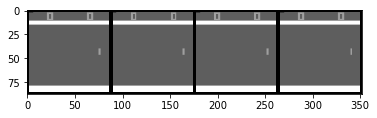

In [4]:
state = env.reset()
plt.imshow(grid_from_state(state), cmap='gray');

## Q-Network
this network will approximate the Q function. It takes a state (4 stacked frames) and outputs a q values for each possible action (Pong has 6 possible actions). Q values are estimates of amount of reward (score) we expect to get at the end of the game.
![dqn](assets/dqn.png)

In [5]:
class DQN(nn.Module):
    """
    deepmind architecture from "Human-level control through deep reinforcement learning"
    https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf
    """
    def __init__(self, num_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, num_actions)

    def forward(self, state):
        x = F.relu(self.conv1(state))  # (20, 20, 32)
        x = F.relu(self.conv2(x))  # (9, 9, 64)
        x = F.relu(self.conv3(x))  # (7, 7, 64)
        x = x.view(x.size(0), -1)  # flatten (7*7*64)
        x = F.relu(self.fc4(x))  # (512)
        q_values = self.fc5(x)  # (num_actions) q value for each action
        return q_values

## Replay Memory
- we want constant time insertion and sampling as this holds 1 million transitions in original paper and must be sampled from on every step.

In [6]:
class ReplayMemory:
    """
    samples are stored as ('state', 'action', 'next_state', 'reward', done)
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.samples = []
        self.insert_location = 0

    def add(self, state, action, reward, next_state, done):
        sample = (state, action, reward, next_state, done)
        if self.insert_location >= len(self.samples):
            self.samples.append(sample)
        else:
            self.samples[self.insert_location] = sample  # assignment is O(1) for lists
        # walk insertion point through list
        self.insert_location = (self.insert_location + 1) % self.capacity

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self.samples))
        batch = random.sample(self.samples, batch_size)
        return self.prepare_batch(batch)

    def prepare_batch(self, batch):
        """
        Transposes and pre-processes batch of transitions into batches of torch tensors
        
        Args:
            batch: list of transitions [[s, a, r, s2, done],
                                        [s, a, r, s2, done]]

        Returns: [s], [a], [r], [s2], [done_mask]
        """
        states, actions, rewards, next_states, done_mask = [], [], [], [], []
        for state, action, reward, next_state, done in batch:
            states.append(process_state(state))
            actions.append(action)
            rewards.append(reward)
            next_states.append(process_state(next_state))
            done_mask.append(1 - done)  # turn True values into zero for mask
        states = torch.cat(states)
        next_states = torch.cat(next_states)
        rewards = torch.FloatTensor(rewards)
        done_mask = torch.FloatTensor(done_mask)
        return states, actions, rewards, next_states, done_mask

    def __len__(self):
        return len(self.samples)

## Action Selection Policy
with probability epsilon, select a random action. otherwise selects action corresponding to highest predicted Q value argmax(Q(S, A)

In [7]:
def select_action(q_network, state, env, epsilon):
    """
    epsilon greedy policy.
    selects action corresponding to highest predicted Q value, otherwise selects
    otherwise selects random action with epsilon probability.
    Args:
        state: current state of the environment (4 stack of image frames)
        epsilon: probability of random action (1.0 - 0.0)

    Returns:(int) action to perform
    """
    if epsilon > random.random():
        return env.action_space.sample()
    state = Variable(process_state(state), volatile=True).cuda()
    return int(q_network(state).data.max(1)[1])

In [8]:
def calculate_epsilon(current_step, epsilon_max=0.9, epsilon_min=0.05, decay_rate=1e-5):
    """
    calculates epsilon value given steps done and speed of decay
    """
    epsilon = epsilon_min + (epsilon_max - epsilon_min) * \
              math.exp(-decay_rate * current_step)
    return epsilon

![q-learning-algorithm](assets/q-learning.png)

## deep q learning (1 episode)

In [9]:
# hyper params
batch_size = 32
gamma = 0.99
learning_rate =1e-4

memory = ReplayMemory(capacity=10000) # initialize replay memory
q_network = DQN(env.action_space.n).cuda() # initialize action-value function Q with random weights
optimizer = Adam(q_network.parameters(), lr=learning_rate)
criterion = nn.SmoothL1Loss()
state = env.reset() # observe initial state

current_step = 0

while True:
    env.render() # so we can watch!
    action = select_action(q_network, state, env, calculate_epsilon(current_step)) # select action
    next_state, reward, done, info = env.step(action)  # carry out action/observe reward
    # store experience s, a, r, s' in replay memory
    memory.add(state, action, reward, next_state, done)

    # sample random transitions
    states, actions, rewards, next_states, done_mask = memory.sample(batch_size)
    
    # prepare batch
    states = Variable(states).cuda()
    next_states = Variable(next_states).cuda()
    rewards = Variable(rewards).cuda()
    done_mask = Variable(done_mask).cuda()

    # calculate target
    # find next Q values and set Q values for done states to 0
    next_q_values = q_network(next_states).max(dim=1)[0].detach() * done_mask
    # calculate targets = rewards + (gamma * next_Q_values)
    targets = rewards + (gamma * next_q_values)

    q_values = q_network(states)[range(len(actions)), actions]  # select only Q values for actions we took
    
    # train network
    loss = criterion(q_values, targets) # smooth l1 loss
    optimizer.zero_grad()
    loss.backward()
    
    # gradient clipping to prevent exploding gradient
    for param in q_network.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    state = next_state # move to next state
    current_step += 1
    if done:
        break

env.close()